# Automatic differentiation with JAX

Look into the slides to get a general intro into automatic differentiation.

## First steps

In [1]:
# !pip install jax jaxlib matplotlib numpy iminuit numba-stats

import jax
from jax import numpy as jnp  # replacement for normal numpy
import numpy as np  # original numpy still needed, since jax does not cover full API
import numba as nb  # will use that later
from matplotlib import pyplot as plt

jax.config.update("jax_enable_x64", True)  # enable float64 precision, default is float32

print(f"JAX version {jax.__version__}")
print(f"numba version {nb.__version__}")

JAX version 0.1.72
numba version 0.51.1


Let's try something simple.

In [2]:
def f(x):
    return 2 + 3 * x ** 2

fprime = jax.grad(f)

Like in a symbolic computation, the object fprime is a real function. You can call it with different values.

In [3]:
f(1.0)

5.0

In [4]:
fprime(1.0)

/usr/local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


DeviceArray(6., dtype=float64)

Jax is designed to compute on the GPU, so it calculates with `DeviceArray`s.

Let's visualize this.

x=-2.0 y=14.0 m=-12.0
x=-1.0 y= 5.0 m= -6.0
x= 0.0 y= 2.0 m=  0.0
x= 1.0 y= 5.0 m=  6.0
x= 2.0 y=14.0 m= 12.0


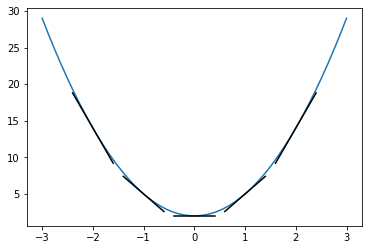

In [5]:
x = np.linspace(-3, 3)
plt.plot(x, f(x))
for xi in np.linspace(-2, 2, 5):
    dx = 0.4
    mi = fprime(xi)
    yi = f(xi)
    print(f"x={xi:4} y={yi:4} m={mi:5}")
    plt.plot([xi-dx, xi, xi+dx], [yi - mi*dx, yi, yi+mi*dx], "-k")

In [6]:
fprime(2.0)

DeviceArray(12., dtype=float64)

In [7]:
x = np.array((1.0, 2.0))
f(x)

array([ 5., 14.])

In [8]:
fprime(x)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (2,).

Ok, we cannot compute a gradient if the function is not $\mathcal{R}^n \to \mathcal{R}$. We need to compute the Jacobian.

In [9]:
fjac = jax.jacfwd(f)

In [10]:
fjac(x)

DeviceArray([[ 6.,  0.],
             [ 0., 12.]], dtype=float64)

There is also `jacrev`.

In [11]:
jax.jacrev(f)(x)

DeviceArray([[ 6.,  0.],
             [ 0., 12.]], dtype=float64)

It always gives the same result (within floating point precision). For $\mathcal{R}^n \to \mathcal{R}^m$, use `jax.jacfwd` if $n \ge m$ and `jax.jacrev` if $m < n$.

In [12]:
def g(x):
    A = ((1., 0.1), (0.1, 2.))
    return np.dot(x, np.dot(A, x))

gprime = jax.grad(g)

In [13]:
g(x)

9.399999999999999

In [14]:
gprime(x)

Exception: The numpy.ndarray conversion method __array__() was called on the JAX Tracer object Traced<ConcreteArray([1. 2.])>with<JVPTrace(level=1/0)>
  with primal = Traced<ConcreteArray([1. 2.]):JaxprTrace(level=0/0)>
       tangent = Traced<ShapedArray(float64[2]):JaxprTrace(level=0/0)>.

This error can occur when a JAX Tracer object is passed to a raw numpy function, or a method on a numpy.ndarray object. You might want to check that you are using `jnp` together with `import jax.numpy as jnp` rather than using `np` via `import numpy as np`. If this error arises on a line that involves array indexing, like `x[idx]`, it may be that the array being indexed `x` is a raw numpy.ndarray while the indices `idx` are a JAX Tracer instance; in that case, you can instead write `jax.device_put(x)[idx]`.

JAX cannot use `numpy` for dynamical code, you need to replace the calls with `jax.numpy`.

In [15]:
def g(x):
    A = ((1., 0.1), (0.1, 2.))
    return jnp.dot(x, jnp.dot(A, x))

gprime = jax.grad(g)
gprime(x)

TypeError: dot requires ndarray or scalar arguments, got <class 'tuple'> at position 0.

... and it does not do implicit conversions like `numpy` for performance reasons.

In [16]:
def g(x):
    A = np.array(((1., 0.1), (0.1, 2.)))
    return jnp.dot(x, jnp.dot(A, x))

gprime = jax.grad(g)
gprime(x)

DeviceArray([2.4, 8.2], dtype=float64)

In [17]:
ghessian = jax.hessian(g)
ghessian(x)

DeviceArray([[2. , 0.2],
             [0.2, 4. ]], dtype=float64)

Rule: Use `np` for constant arguments. Use `jnp` for variable arguments. That is the official recommendation.

What happens if a function has several parameters?

In [18]:
def f(x, a):
    return 3 * x ** 2 + a

fprime = jax.grad(f)
fprime(3.0, 1.0)

DeviceArray(18., dtype=float64)

Jax computes the derivative with respect to the first argument by default.

## Second steps

In [19]:
from numba_stats import norm_cdf

norm_pdf = jax.grad(norm_cdf)

In [20]:
norm_cdf(0, 1, 1)

0.15865525393145707

In [21]:
norm_pdf(0, 1, 1)

TypeError: grad requires real- or complex-valued inputs (input dtype that is a sub-dtype of np.floating or np.complexfloating), but got int64. 

JAX cannot derive code that is not expressible in JAX primitives. You have to express your code using `jax.numpy` and `jax.scipy` (see next example).

It is possible to teach JAX about new primitives. This is well explained in the JAX docs with a nice tutorial, but that is too involved to cover here.

There is a comparabily simple way to help JAX with some derivatives, where a human knowns a faster/more accurate way to calculate the derivate. I cannot present this here, but it is fairly easy to set up. Please see the excellent JAX docs/tutorials on this topic.

## Practical example A: Fit of a gaussian model to a histogram

We fit a gaussian to a histogram using a maximum-likelihood approach based on Poisson statistics. This example is used to investigate how automatic differentiation can accelerate a typical fit in a counting experiment.

To compare fits with and without passing an analytic gradient fairly, we use `Minuit.strategy = 0`, which prevents Minuit from automatically computing the Hesse matrix after the fit.

In [22]:
from jax.scipy.special import erf  # replacement for scipy.special.erf
from iminuit import Minuit

We generate some toy data and write the negative log-likelihood (nll) for a fit to binned data, assuming Poisson-distributed counts.

**Note:** We write all statistical functions in pure Python code, to demonstrate Jax's ability to automatically differentiate and JIT compile this code. In practice, one should import JIT-able statistical distributions from jax.scipy.stats. The library versions can be expected to have fewer bugs and to be faster and more accurate than hand-written code.

In [23]:
# generate some toy data
rng = np.random.default_rng(seed=1)
n, xe = np.histogram(rng.normal(size=10000), bins=1000)


def cdf(x, mu, sigma):
    # cdf of a normal distribution, needed to compute the expected counts per bin
    # better alternative for real code: from jax.scipy.stats.norm import cdf
    z = (x - mu) / sigma
    return 0.5 * (1 + erf(z / np.sqrt(2)))


def nll(par):  # negative log-likelihood with constants stripped
    amp = par[0]
    mu, sigma = par[1:]
    p = cdf(xe, mu, sigma)
    mu = amp * jnp.diff(p)
    result = jnp.sum(mu - n + n * jnp.log(n / (mu + 1e-100) + 1e-100))
    return result

Let's check results from all combinations of using JIT and gradient and then compare the execution times.

|      |     |     |
|:----:|:---:|:---:|
|      |~JIT~| JIT |
|~grad~| m1  | m3  |
| grad | m2  | m4  |

In [24]:
start_values = (1.5 * np.sum(n), 1.0, 2.0)
limits = ((0, None), (None, None), (0, None))


def make_and_run_minuit(fcn, grad=None):
    m = Minuit(fcn, start_values, grad=grad, name=("amp", "mu", "sigma"))
    m.errordef = Minuit.LIKELIHOOD
    m.limits = limits
    m.strategy = 0 # do not explicitly compute hessian after minimisation
    m.migrad()
    return m

In [25]:
m1 = make_and_run_minuit(nll)
m1.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 496.2                      │              Nfcn = 66               │
│ EDM = 1.84e-08 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [26]:
m2 = make_and_run_minuit(nll, grad=jax.grad(nll))
m2.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 496.2                      │              Nfcn = 26               │
│ EDM = 1.84e-08 (Goal: 0.0001)    │              Ngrad = 6               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [27]:
m3 = make_and_run_minuit(jax.jit(nll), grad=jax.grad(nll))
m3.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 496.2                      │              Nfcn = 26               │
│ EDM = 1.88e-08 (Goal: 0.0001)    │              Ngrad = 6               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [28]:
m4 = make_and_run_minuit(jax.jit(nll), grad=jax.jit(jax.grad(nll)))
m4.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 496.2                      │              Nfcn = 26               │
│ EDM = 1.88e-08 (Goal: 0.0001)    │              Ngrad = 6               │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [29]:
from numba_stats import norm_cdf # numba jit-able version of norm.cdf

@nb.njit
def nb_nll(par):  # negative log-likelihood with constants stripped
    amp = par[0]
    mu, sigma = par[1:]
    p = norm_cdf(xe, mu, sigma)
    mu = amp * np.diff(p)
    result = np.sum(mu - n + n * np.log(n / (mu + 1e-323) + 1e-323))
    return result

m5 = make_and_run_minuit(nb_nll)
m5.fmin

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 496.2                      │              Nfcn = 82               │
│ EDM = 5.31e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘

In [30]:
from timeit import timeit

times = {
    "no JIT, no grad": "m1",
    "no JIT, grad": "m2",
    "jax JIT, no grad": "m3",
    "jax JIT, grad": "m4",
    "numba JIT, no grad": "m5",
}
for k, v in times.items():
    t = timeit(
        f"{v}.values = start_values; {v}.migrad()",
        f"from __main__ import {v}, start_values",
        number=1,
    )
    times[k] = t

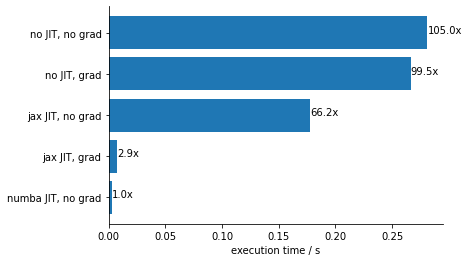

In [31]:
from matplotlib import pyplot as plt

x = np.fromiter(times.values(), dtype=float)
xmin = np.min(x)

y = -np.arange(len(times))
plt.barh(y, x)
for yi, k, v in zip(y, times, x):
    plt.text(v, yi, f"{v/xmin:.1f}x")
plt.yticks(y, times.keys())
for loc in ("top", "right"):
    plt.gca().spines[loc].set_visible(False)
plt.xlabel("execution time / s");

Conclusions:

1. As expected, the best results are obtained by JIT compiling the function and the gradient.

2. Without using the gradient, JIT compiling the cost function with Jax is relatively a minor performance improvement. Numba is able to do much better, because it directly generates optimized machine code, using the powerful optimizer from LLVM.

3. JIT compiling the gradient is very important. Using a Python-computed gradient is only a minor performance improvement in this example. This may change if the model has a large number of parameters (>> 10).

The gain from using a gradient is larger for functions with hundreds of parameters, as is common in machine learning. Human-made models often have less than 10 parameters, and then the gain is not so dramatic. 

### Computing covariance matrices with JAX

Automatic differentiation gives us another way to compute uncertainties of fitted parameters. MINUIT compute the uncertainties with the HESSE algorithm by default, which computes the matrix of second derivates approximately using finite differences and inverts this.

Let's compare the output of HESSE with the exact (within floating point precision) computation using automatic differentiation.

In [32]:
m4.hesse()
cov_hesse = m4.covariance


def jax_covariance(par):
    return jnp.linalg.inv(jax.hessian(nll)(par))


par = np.array(m4.values)
cov_jax = jax_covariance(par)

print(
    f"sigma[amp]  : HESSE = {cov_hesse[0, 0] ** 0.5:6.1f}, JAX = {cov_jax[0, 0] ** 0.5:6.1f}"
)
print(
    f"sigma[mu]   : HESSE = {cov_hesse[1, 1] ** 0.5:6.4f}, JAX = {cov_jax[1, 1] ** 0.5:6.4f}"
)
print(
    f"sigma[sigma]: HESSE = {cov_hesse[2, 2] ** 0.5:6.4f}, JAX = {cov_jax[2, 2] ** 0.5:6.4f}"
)

sigma[amp]  : HESSE =  100.0, JAX =  100.0
sigma[mu]   : HESSE = 0.0100, JAX = 0.0100
sigma[sigma]: HESSE = 0.0071, JAX = 0.0071


Success, HESSE and JAX give the same answer within the  relevant precision.

**Note:** If you compute the covariance matrix in this way from a least-squares cost function, you must multiply it by 2.

Let us compare the performance of HESSE with Jax.

In [33]:
%%timeit -n 1 -r 3
m = Minuit(nll, par)
m.errordef = Minuit.LIKELIHOOD
m.hesse()

90.3 ms ± 3.37 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [34]:
%%timeit -n 1 -r 3
jax_covariance(par)

53.2 ms ± 4.73 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


The computation with Jax is faster, but not by much. It is also more accurate (although the added precision is not relevant).

Altogether, Minuit's HESSE algorithm still makes sense today. It has the advantage that it can process any function, while Jax cannot. Jax cannot differentiate a function that calls into C/C++ code or Cython code, for example.

Final note: If we JIT compile `jax_covariance`, it greatly outperforms Minuit's HESSE algorithm, but that only makes sense if you need to compute the hessian at different parameter values, so that the extra time spend to compile is balanced by the time saved over many invokations. This is not what happens here, the Hessian in only needed at the best fit point.

In [35]:
%%timeit -n 1 -r 3 jit_jax_covariance = jax.jit(jax_covariance); jit_jax_covariance(par)
jit_jax_covariance(par)

253 µs ± 19.1 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)


It is much faster... but only because the compilation cost is excluded here.

In [36]:
%%timeit -n 1 -r 1
# if we include the JIT compilation cost, the performance drops dramatically
@jax.jit
def jax_covariance(par):
    return jnp.linalg.inv(jax.hessian(nll)(par))


jax_covariance(par)

565 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


With compilation cost included, it is much slower.

Conclusion: Using the JIT compiler makes a lot of sense if the covariance matrix has to be computed repeatedly for the same cost function but different parameters, but this is not the case when we use it to compute parameter errors.

## Practical example B: Fit data points with uncertainties in x and y

Let's say we have some data points $(x_i \pm \sigma_{x,i}, y_i \pm \sigma_{y,i})$ and we have a model $y=f(x)$ that we want to adapt to this data. If $\sigma_{x,i}$ was zero, we could use the usual least-squares method, minimizing the sum of squared residuals $r^2_i = (y_i - f(x_i))^2 / \sigma^2_{y,i}$. Here, we don't know where to evaluate $f(x)$, since the exact $x$-location is only known up to $\sigma_{x,i}$.

We can approximately extend the standard least-squares method to handle this case. We use that the uncertainty along the $x$-axis can be converted into an additional uncertainty along the $y$-axis with error propagation,
$$
f(x_i \pm \sigma_{x,i}) \simeq f(x_i) \pm f'(x_i)\,\sigma_{x,i}.
$$
Using this, we obtain modified squared residuals
$$
r^2_i = \frac{(y_i - f(x_i))^2}{\sigma^2_{y,i} + (f'(x_i) \,\sigma_{x,i})^2}.
$$

We demonstrate this with a fit of a polynomial.

In [37]:
# polynomial model
def f(x, par):
    return jnp.polyval(par, x)


# true polynomial f(x) = x^2 + 2 x + 3
par_true = (1, 2, 3)


# grad computes derivative with respect to the first argument
f_prime = jax.jit(jax.grad(f))


# checking first derivative f'(x) = 2 x + 2
assert f_prime(0.0, par_true) == 2
assert f_prime(1.0, par_true) == 4
assert f_prime(2.0, par_true) == 6
# ok!

# generate toy data
n = 30
data_x = np.linspace(-4, 7, n)
data_y = f(data_x, par_true)

rng = np.random.default_rng(seed=1)
sigma_x = 0.5
sigma_y = 5
data_x += rng.normal(0, sigma_x, n)
data_y += rng.normal(0, sigma_y, n)

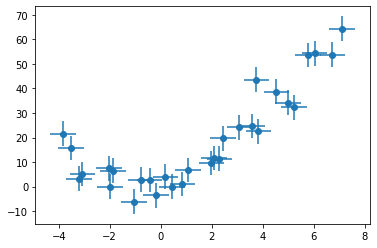

In [38]:
plt.errorbar(data_x, data_y, sigma_y, sigma_x, fmt="o");

In [39]:
# define the cost function
@jax.jit
def cost(par):
    result = 0.0
    for xi, yi in zip(data_x, data_y):
        y_var = sigma_y ** 2 + (f_prime(xi, par) * sigma_x) ** 2
        result += (yi - f(xi, par)) ** 2 / y_var
    return result

cost.errordef = Minuit.LEAST_SQUARES

# test the jit-ed function
cost(np.zeros(3))

DeviceArray(876.49545695, dtype=float64)

In [40]:
m = Minuit(cost, np.zeros(3))
m.migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 23.14                      │              Nfcn = 91               │
│ EDM = 3.12e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │   1.25    │   0.15    │            │            │         │         │       │
│ 1 │ x1   │    1.5    │    0.5    │            │            │         │         │       │
│ 2 │ x2   │    1.6    │    1.5    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────────────────────┐
│    │      x0      x1      x2 │
├────┼─────────────────────────┤
│ x0 │  0.0223 -0.0388   -0.15 │
│ x1 │ -0.0388    0.24   0.172 │
│ x2 │   -0.15   0.172    2.32 │
└────┴─────────────────────────┘

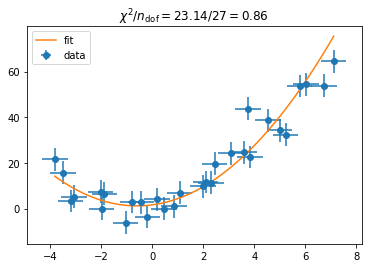

In [41]:
plt.errorbar(data_x, data_y, sigma_y, sigma_x, fmt="o", label="data")
x = np.linspace(data_x[0], data_x[-1], 200)
plt.plot(x, f(x, m.values), label="fit")
plt.legend()

# check fit quality
chi2 = m.fval
ndof = len(data_y) - 3
plt.title(f"$\\chi^2 / n_\\mathrm{{dof}} = {chi2:.2f} / {ndof} = {chi2/ndof:.2f}$");

We obtained a good fit.